In [56]:
import pandas as pd
import numpy as np

from gensim.utils import simple_preprocess

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy #pos# should i also try to do tokenization?


import gensim
from gensim.models import Word2Vec, KeyedVectors


from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.pipeline import Pipeline





In [57]:
df=pd.read_csv('cleaned_tmdb_movies.csv')
df.head(1)

,title,overview,genre_ids,genre_names
0,Zootopia 2,After cracking the biggest case in Zootopia's ...,"16,35,12,10751,9648","Animation,Comedy,Adventure,Family,Mystery"


In [58]:
#simple preprocesing
df['overview']=df['overview'].astype(str).apply(lambda x: simple_preprocess(x, min_len=2))
df['overview'].head(1)

0    [after, cracking, the, biggest, case, in, zoot...
Name: overview, dtype: object

In [59]:
len(df['overview'])

9980

In [60]:
#pos tagging
#POS taggers are designed to work on tokenized words, not on raw text.
nlp=spacy.load('en_core_web_sm')
df['overview']=df['overview'].astype(str)
#df['overview']=(df['overview']).apply(nlp)#replace this sentence with df
df['doc'] = df['overview'].apply(nlp)





In [61]:
spacy.explain('X')

'other'

In [62]:
#[print(token.pos_ ) for token in df['doc'][0]]

In [63]:
len(df['doc'][0])

245

In [64]:
len(df['doc'])

9980

In [65]:
#keep only pos that will be useful for genre classification
KEEP_POS = {"NOUN", "VERB", "ADJ"}

df['tokens'] = df['doc'].apply(
    lambda doc: [
        token.text.lower()
        for token in doc
        if token.pos_ in KEEP_POS and token.is_alpha
    ]
)




In [66]:
df['tokens']

0       [cracking, biggest, case, history, rookie, cop...
1       [desperate, save, sick, daughter, working, cla...
2       [young, duplenticy, sent, assist, charismatic,...
3       [reclusive, survivalist, daughter, rescue, mys...
4       [sophisticated, program, called, ares, sent, d...
                              ...                        
9975    [captures, performance, battle, pride, held, y...
9976    [angel, falls, mountain, ski, resort, erupt, v...
9977    [failed, suicide, attempt, leaves, crippled, r...
9978    [lengthy, detailed, examination, making, film,...
9979    [having, lost, memory, girl, wanders, desert, ...
Name: tokens, Length: 9980, dtype: object

In [67]:
print((token.tag_ )for token in df['tokens'][0])

<generator object <genexpr> at 0x000001F2C39C18C0>


In [68]:
df['tokens'].shape

(9980,)

In [69]:
len(df['tokens'][0])

34

In [70]:
df['doc']

0       ([, ', after, ', ,, ', cracking, ', ,, ', the,...
1       ([, ', desperate, ', ,, ', to, ', ,, ', save, ...
2       ([, ', when, ', ,, ', young, ', ,, ', priest, ...
3       ([, ', when, ', ,, ', reclusive, ', ,, ', surv...
4       ([, ', highly, ', ,, ', sophisticated, ', ,, '...
                              ...                        
9975    ([, ', captures, ', ,, ', the, ', ,, ', perfor...
9976    ([, ', angel, ', ,, ', falls, ', ,, ', is, ', ...
9977    ([, ', after, ', ,, ', failed, ', ,, ', suicid...
9978    ([, ', lengthy, ', ,, ', and, ', ,, ', detaile...
9979    ([, ', having, ', ,, ', lost, ', ,, ', her, ',...
Name: doc, Length: 9980, dtype: object

In [71]:
EXCLUDE_POS = {"SPACE", "X", "SYM"}

df['tokens'] = df['doc'].apply(
    lambda doc: [
        token.text.lower()
        for token in doc
        if token.pos_ not in EXCLUDE_POS and token.is_alpha
    ]
)


In [72]:
#save df[tokens] to csv
df[['tokens']].to_csv('tokenized_movies.csv', index=False)

In [73]:
len(df['doc'][0]), len(df['tokens'][0])

(245, 60)

In [80]:
#feature engineering
#w2v: shallow-ANN>>learns embedding of words

tokenized_corpus = df['tokens'].tolist()
w2v_model = Word2Vec(sentences=tokenized_corpus, vector_size=300,
    window=10,
    min_count=2,
    sg=1  # skip-gram >>for sementic
)


In [81]:
import torch
torch.save(w2v_model.wv, 'w2v_embeddings.pth')

In [79]:
len (tokenized_corpus[0])

60

In [82]:


#len(w2v_model.wv) #vocabulary size
#print(w2v_model.wv['good'] )#to get vector representation
print(w2v_model.wv.similarity("good", "bad")) #cosine similarity between two words

#apply pca to get representation

0.763862


In [83]:
print(w2v_model.wv.most_similar("best") )#most similar words to king


[('bad', 0.6869555711746216), ('friend', 0.6863865256309509), ('favorite', 0.6750028133392334), ('close', 0.6641491055488586), ('imaginary', 0.6420208215713501), ('seller', 0.6419796943664551), ('hank', 0.6414389610290527), ('agnes', 0.6400976181030273), ('hits', 0.6364421844482422), ('ready', 0.6358477473258972)]


In [84]:
print(w2v_model.get_latest_training_loss())


0.0


In [85]:
print(w2v_model.wv.get_normed_vectors().shape)
#print(w2v_model.wv.get_normed_vectors())
print(w2v_model.wv.index_to_key)
#output shape is  vocab size, num of features

(17097, 300)
['the', 'to', 'and', 'of', 'in', 'his', 'is', 'with', 'her', 'he', 'for', 'on', 'an', 'that', 'by', 'as', 'their', 'who', 'from', 'when', 'but', 'they', 'she', 'has', 'at', 'are', 'him', 'life', 'it', 'after', 'into', 'one', 'this', 'new', 'up', 'young', 'be', 'out', 'world', 'family', 'all', 'man', 'will', 'two', 'about', 'them', 'have', 'love', 'was', 'not', 'film', 'old', 'find', 'story', 'time', 'years', 'woman', 'only', 'nan', 'father', 'where', 'must', 'while', 'can', 'which', 'get', 'friends', 'back', 'finds', 'year', 'first', 'other', 'home', 'through', 'war', 'wife', 'what', 'help', 'more', 'before', 'town', 'against', 'own', 'daughter', 'mother', 'himself', 'son', 'during', 'most', 'girl', 'between', 'lives', 'been', 'takes', 'take', 'city', 'three', 'now', 'friend', 'day', 'over', 'also', 'way', 'off', 'group', 'people', 'together', 'becomes', 'no', 'there', 'soon', 'so', 'being', 'school', 'its', 'death', 'make', 'some', 'down', 'or', 'documentary', 'mysterious

In [128]:
MAX_LEN = 100
EMBED_DIM = w2v_model.vector_size

def document_sequence(tokens):
    seq = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]

    # truncate
    seq = seq[:MAX_LEN]
    #print(len(seq))
    # pad
    if len(seq) < MAX_LEN:
        pad = np.zeros((MAX_LEN - len(seq), EMBED_DIM))
        seq = np.vstack([seq, pad])
        #(print(len(seq)))
    return seq


X = np.array(df['tokens'].apply(document_sequence).tolist())
#X.shape = (num_docs, MAX_LEN, 300)


In [130]:
X.shape

(9980, 100, 300)

In [87]:
# Ensure `genre_names` has no NaNs and convert to lists
# Replace NaNs with empty string so split is safe
df['genre_names'] = df['genre_names'].fillna('')
# Convert to lists of genres (empty list for missing); strip whitespace and ignore empty labels
y_lists = df['genre_names'].apply(lambda x: [g.strip() for g in x.split(',') if g.strip()] if x else [])

y_lists

0       [Animation, Comedy, Adventure, Family, Mystery]
1                   [Action, Thriller, Science Fiction]
2                            [Thriller, Mystery, Drama]
3                             [Action, Drama, Thriller]
4                  [Science Fiction, Adventure, Action]
                             ...                       
9975                                            [Music]
9976                                    [Drama, Action]
9977                                            [Drama]
9978                                      [Documentary]
9979                        [Animation, Drama, Fantasy]
Name: genre_names, Length: 9980, dtype: object

In [88]:
df['genre_list'] = y_lists
all_genres = [genre for sublist in df['genre_list'] for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()

count=0
for i in genre_counts:
    count+=1
print("Total unique genres:", count)

#each genre count
for genre, cnt in genre_counts.items():
    print(f"{genre}: {cnt}")

Total unique genres: 19
Drama: 3463
Comedy: 3152
Action: 1611
Thriller: 1413
Adventure: 1266
Romance: 1155
Documentary: 1094
Crime: 1045
Family: 934
Fantasy: 813
Horror: 805
TV Movie: 780
Animation: 762
Science Fiction: 684
Mystery: 529
Music: 491
History: 430
War: 272
Western: 253


In [89]:
'''#dont do label encoding/ because genre are multiple
#perform multilabel binarization
mlb = MultiLabelBinarizer()
y= df['genre_names'].apply(lambda x: x.split(','))
#y = mlb.fit_transform(df['genre_names'])
'''

"#dont do label encoding/ because genre are multiple\n#perform multilabel binarization\nmlb = MultiLabelBinarizer()\ny= df['genre_names'].apply(lambda x: x.split(','))\n#y = mlb.fit_transform(df['genre_names'])\n"

In [90]:
#dont do label encoding/ because genre are multiple
#perform multilabel binarization

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_lists)

from scipy import sparse
y_sparse = sparse.csr_matrix(y)

print("num classes:", len(mlb.classes_), "y shape:", y.shape)
print("sample classes:", mlb.classes_[:10])

num classes: 19 y shape: (9980, 19)
sample classes: ['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary' 'Drama'
 'Family' 'Fantasy' 'History']


In [91]:
y_sparse

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 20952 stored elements and shape (9980, 19)>

In [92]:
df['genre_names'].head(1)

0    Animation,Comedy,Adventure,Family,Mystery
Name: genre_names, dtype: object

In [93]:
print(y[0])

[0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]


In [126]:
X_train[-1]

tensor([[-1.5991e-03,  1.3721e-01, -2.1172e-04,  ..., -2.0403e-02,
          1.1238e-01, -1.3708e-02],
        [ 1.8450e-02,  1.2162e-01,  2.3054e-02,  ..., -1.4206e-02,
          9.7707e-02, -1.7368e-02],
        [ 1.7784e-01,  2.1843e-01, -3.4535e-01,  ...,  1.0615e-01,
         -1.3685e-02, -2.5382e-01],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

In [137]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

class LSTMGenreClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, 50, 1, batch_first=True)
        self.fc = nn.Linear(50, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device)
        out, _ = self.lstm1(x, (h0, c0))
        #(batch_size, seq_len, hidden_dim) ..out, (hn,cn)

        out, _ = self.lstm2(out)
        out = self.fc(out[:, -1, :])
        return out


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

print(X_train.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


pos_counts = y_train.sum(axis=0)
neg_counts = y_train.shape[0] - pos_counts
pos_weight = neg_counts / (pos_counts +0.001 )#1e-6
pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)#,sampler=sampler

input_dim = X_train.shape[2]
hidden_dim = 100
output_dim = y_train.shape[1]


lstm_model = LSTMGenreClassifier(input_dim, hidden_dim, output_dim).to(device)
#criterion = nn.BCEWithLogitsLoss()
#criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

num_epochs = 50
from tqdm import tqdm

for epoch in range(num_epochs):
    lstm_model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in tqdm( train_loader,desc=f"Epoch {epoch+1}/{num_epochs}",leave=False):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Loss: {epoch_loss / len(train_loader):.4f}"
    )

C:\Users\Aliza Momin\AppData\Local\Temp\ipykernel_6056\1753780221.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)


torch.Size([7984, 100, 300])


Epoch [1/50] Loss: 1.2337


Epoch [2/50] Loss: 1.2313


Epoch [3/50] Loss: 1.2329


Epoch [4/50] Loss: 1.2315


Epoch [5/50] Loss: 1.2090


Epoch [6/50] Loss: 1.1641


Epoch [7/50] Loss: 1.1446


Epoch [8/50] Loss: 1.1222


Epoch [9/50] Loss: 1.0821


Epoch [10/50] Loss: 1.0586


Epoch [11/50] Loss: 1.0388


Epoch [12/50] Loss: 1.0222


Epoch [13/50] Loss: 1.0081


Epoch [14/50] Loss: 0.9973


Epoch [15/50] Loss: 0.9906


Epoch [16/50] Loss: 0.9542


Epoch [17/50] Loss: 0.9362


Epoch [18/50] Loss: 0.9172


Epoch [19/50] Loss: 1.0446


Epoch [20/50] Loss: 0.9084


Epoch [21/50] Loss: 0.8812


Epoch [22/50] Loss: 0.8631


Epoch [23/50] Loss: 0.8512


Epoch [24/50] Loss: 0.8380


Epoch [25/50] Loss: 0.8202


Epoch [26/50] Loss: 0.8065


Epoch [27/50] Loss: 0.8008


Epoch [28/50] Loss: 0.7708


Epoch [29/50] Loss: 0.7781


Epoch [30/50] Loss: 0.7560


Epoch [31/50] Loss: 0.7332


Epoch [32/50] Loss: 0.7202


Epoch [33/50] Loss: 0.7116


Epoch [34/50] Loss: 0.6928


Epoch [35/50] Loss: 0.6957


Epoch [36/50] Loss: 0.6736


Epoch [37/50] Loss: 0.6710


Epoch [38/50] Loss: 0.6621


Epoch [39/50] Loss: 0.6318


Epoch [40/50] Loss: 0.6342


Epoch [41/50] Loss: 0.6065


Epoch [42/50] Loss: 0.6067


Epoch [43/50] Loss: 0.5837


Epoch [44/50] Loss: 0.5852


Epoch [45/50] Loss: 0.5794


Epoch [46/50] Loss: 0.5578


Epoch [47/50] Loss: 0.5568


Epoch [48/50] Loss: 0.5313


Epoch [49/50] Loss: 0.5441


Epoch [50/50] Loss: 0.5231


In [ ]:
'''import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

class RNNGenreClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.rnn1 = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.rnn2 = nn.RNN(hidden_dim, 50, num_layers, batch_first=True)
        self.fc = nn.Linear(50, output_dim)

    def forward(self, x):
        h0 = torch.zeros(
            self.num_layers,
            x.size(0),
            self.hidden_dim,
            device=x.device
        )
        out, _ = self.rnn1(x, h0)
        out, _ = self.rnn2(out)
        out = self.fc(out[:, -1, :])  # last timestep
        return out


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
'''
'''
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# y_train shape = (num_samples, num_classes)
# compute weights per class

class_weights = []
for i in range(y_train.shape[1]):
    weights = compute_class_weight('balanced',classes=np.array([0, 1]), y=y_train[:,i].cpu().numpy())
    class_weights.append(weights[1])  # weight for positive class

class_weights = torch.FloatTensor(class_weights).to(device)
'''
'''
from torch.utils.data import WeightedRandomSampler
# compute weights for each sample
# higher weight for samples of rare genres
class_counts = y_train.sum(axis=0)  # num samples per class
weights_per_sample = np.zeros(len(y_train))

for i in range(len(y_train)):
    sample_weight = 0
    for j in range(y_train.shape[1]):
        if y_train[i, j] == 1:
            sample_weight += 1.0 / class_counts[j]
    weights_per_sample[i] = sample_weight

sampler = WeightedRandomSampler(weights_per_sample, num_samples=len(weights_per_sample), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=8,sampler=sampler, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8,sampler=sampler, shuffle=False)

input_dim = X_train.shape[2]
hidden_dim = 100
output_dim = y_train.shape[1]


rnn_model = RNNGenreClassifier(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
#criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)

optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

num_epochs = 30
from tqdm import tqdm

for epoch in range(num_epochs):
    rnn_model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{num_epochs}",
        leave=False
    ):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = rnn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Loss: {epoch_loss / len(train_loader):.4f}"
    )

'''

In [138]:
with torch.no_grad():
    test_tensor=torch.FloatTensor(X_test)
    logits = lstm_model(test_tensor)
    probs = torch.sigmoid(logits)
print(probs.mean(), probs.min(), probs.max())

'''
mean ≈ 0.01 → bad
mean ≈ 0.1-0.3 → learning

'''


tensor(0.2534) tensor(7.6315e-08) tensor(0.9992)


'\nmean ≈ 0.01 → bad\nmean ≈ 0.1-0.3 → learning\n\n'

In [146]:
# Word2Vec
''''''
import pickle

w2v_model.save("w2v_tmdb.model")

# RNN
torch.save({
    "model_state": lstm_model.state_dict(),
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "output_dim": output_dim
}, "rnn_genre_full.pt")

# Binarizer
with open("mlb.pkl", "wb") as f:
    pickle.dump(mlb, f)


In [150]:
lstm_model.eval()
with torch.no_grad():
    X_test= torch.FloatTensor(X_test)
    y_test= torch.FloatTensor(y_test)
    predicted = lstm_model(X_test)
    print(predicted[-1])
    logits = lstm_model(X_test)
    probs = torch.sigmoid(logits)
    y_pred = (probs >= 0.8).int().cpu().numpy()

    print("RNN Classification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))
'''
Some classes have recall = 1.00

→ model predicts them for every sample

Precision is low

→ many false positives

Other classes have no predicted positives

→ precision undefined → sklearn warning



≥ 0.6	Genre is present	1
< 0.6	Genre is absent	    0
'''

tensor([-3.7487, -4.4883, -5.7285,  0.6402, -1.9281, -6.2001,  1.0460, -2.4242,
        -1.9696, -7.2954, -2.7784, -6.2227, -2.8210,  1.2488, -4.6740,  1.1354,
        -0.9868, -6.8789, -5.7081])
RNN Classification Report:
                  precision    recall  f1-score   support

         Action       0.60      0.54      0.57       323
      Adventure       0.47      0.41      0.44       255
      Animation       0.44      0.57      0.50       169
         Comedy       0.59      0.05      0.09       652
          Crime       0.40      0.46      0.43       199
    Documentary       0.65      0.70      0.68       222
          Drama       0.64      0.15      0.24       701
         Family       0.47      0.61      0.53       181
        Fantasy       0.34      0.51      0.41       157
        History       0.28      0.58      0.37        85
         Horror       0.40      0.47      0.43       137
          Music       0.32      0.42      0.36        96
        Mystery       0.29      0.

c:\Users\Aliza Momin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Aliza Momin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Aliza Momin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior

'\nSome classes have recall = 1.00\n\n→ model predicts them for every sample\n\nPrecision is low\n\n→ many false positives\n\nOther classes have no predicted positives\n\n→ precision undefined → sklearn warning\n\n\n\n≥ 0.6\tGenre is present\t1\n< 0.6\tGenre is absent\t    0\n'

Genre: Action


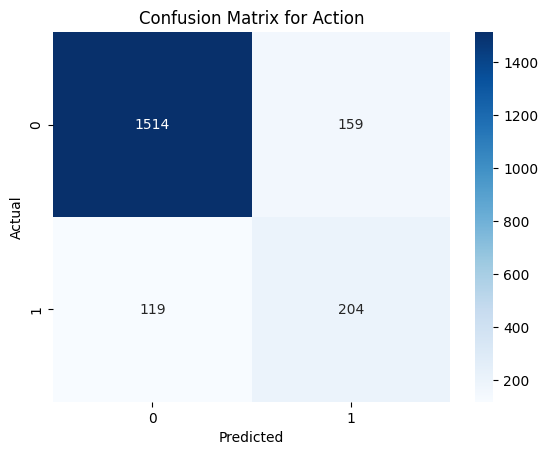

Genre: Adventure


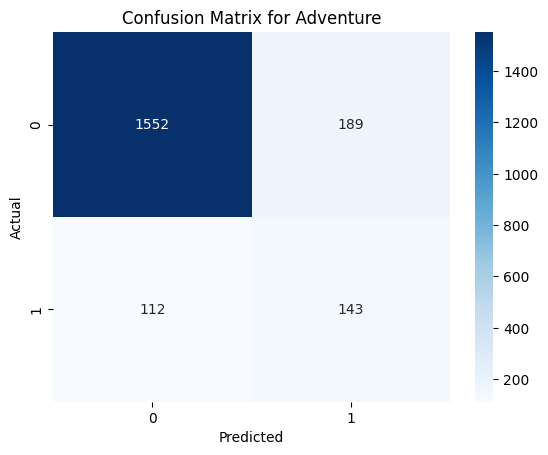

Genre: Animation


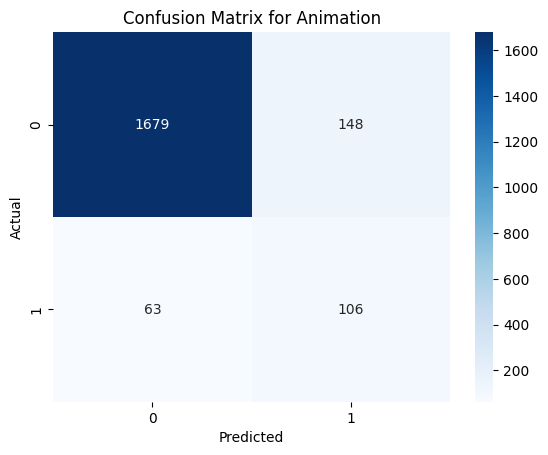

Genre: Comedy


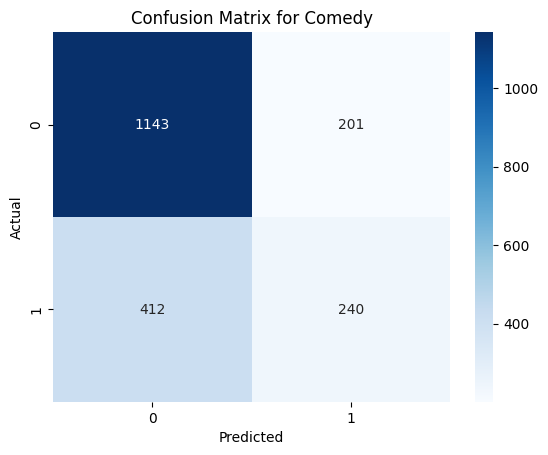

Genre: Crime


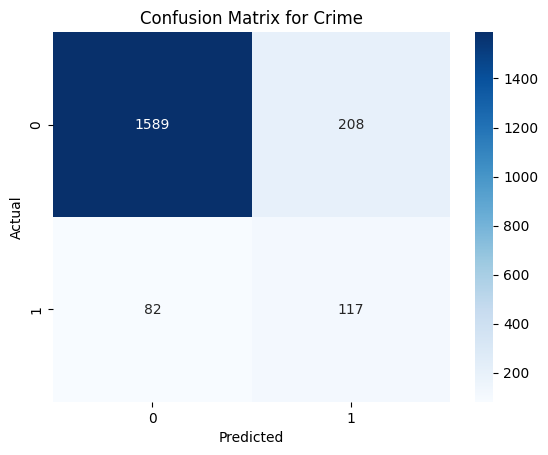

Genre: Documentary


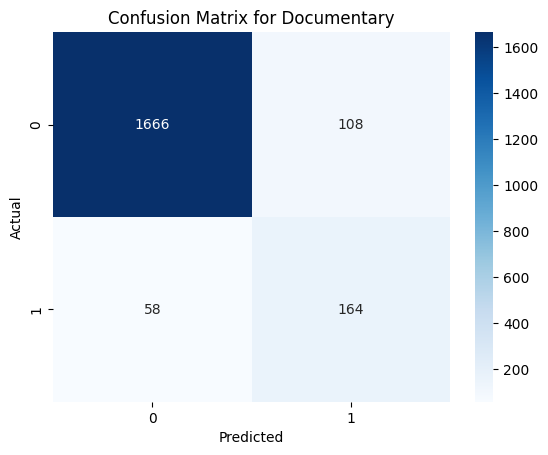

Genre: Drama


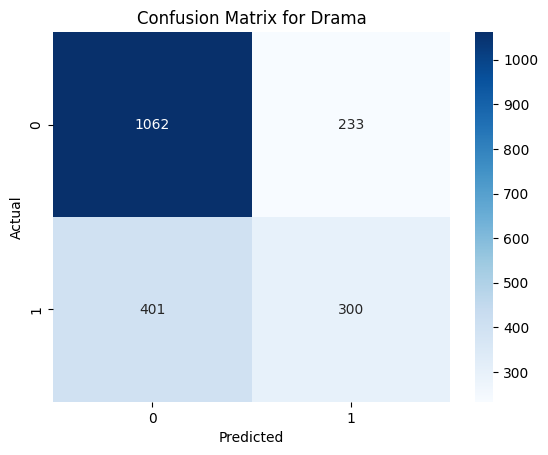

Genre: Family


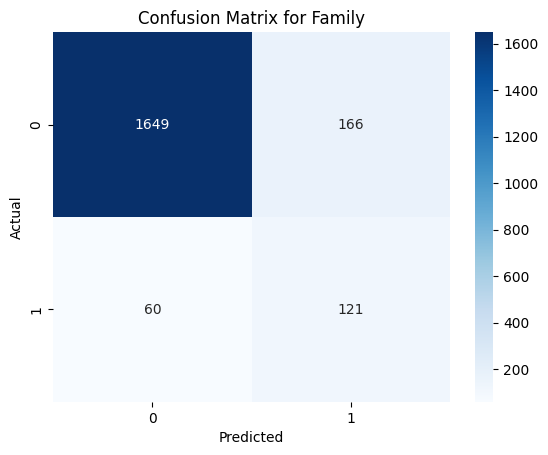

Genre: Fantasy


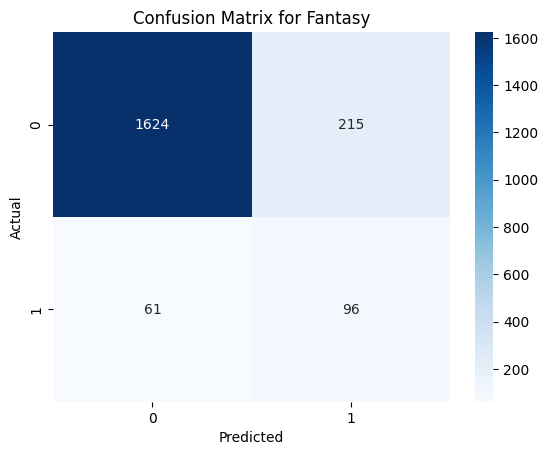

Genre: History


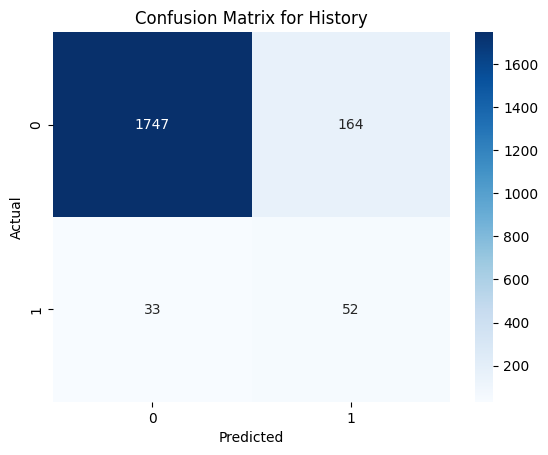

Genre: Horror


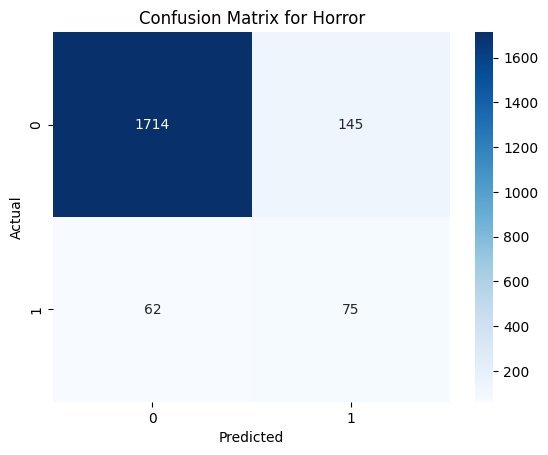

Genre: Music


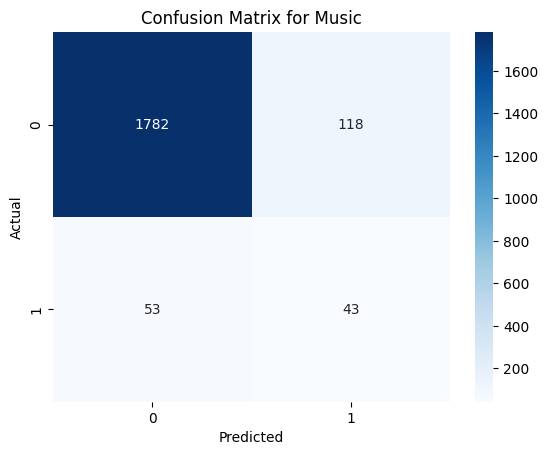

Genre: Mystery


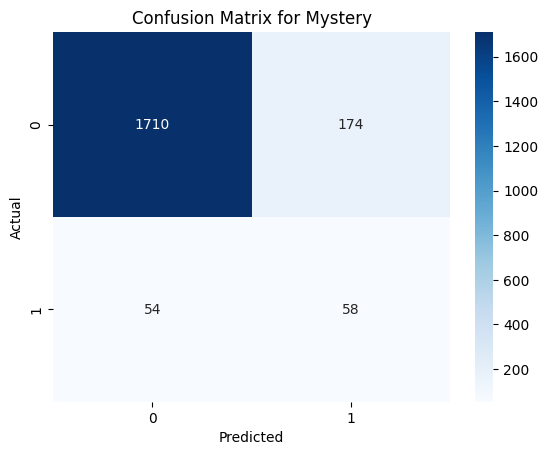

Genre: Romance


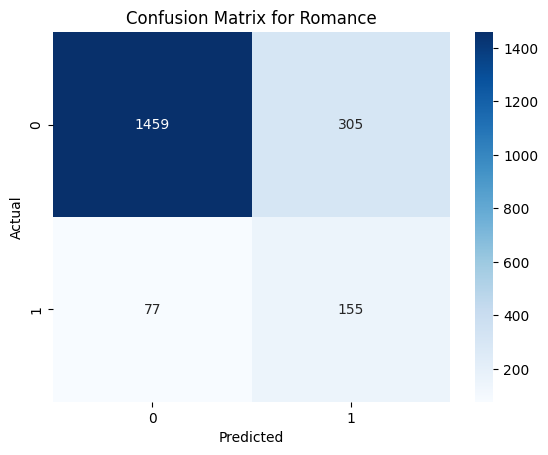

Genre: Science Fiction


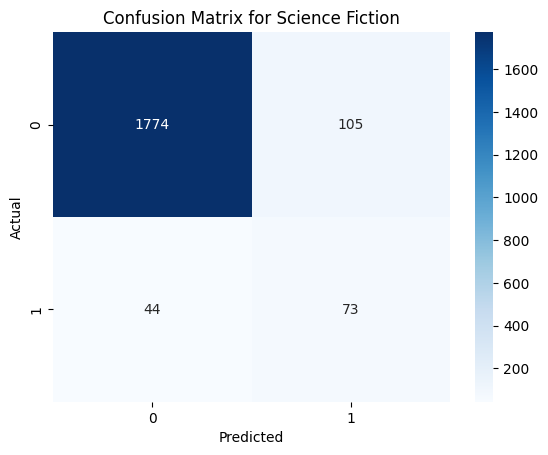

Genre: TV Movie


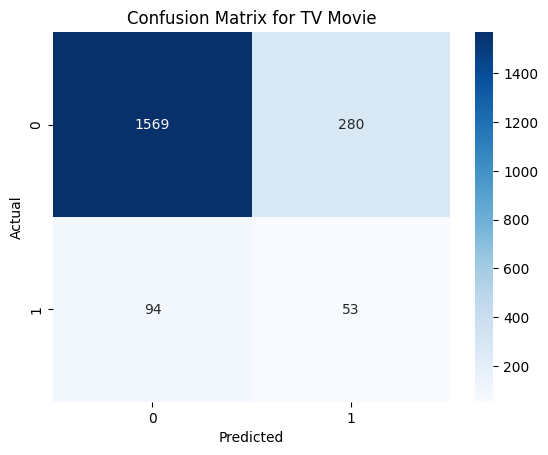

Genre: Thriller


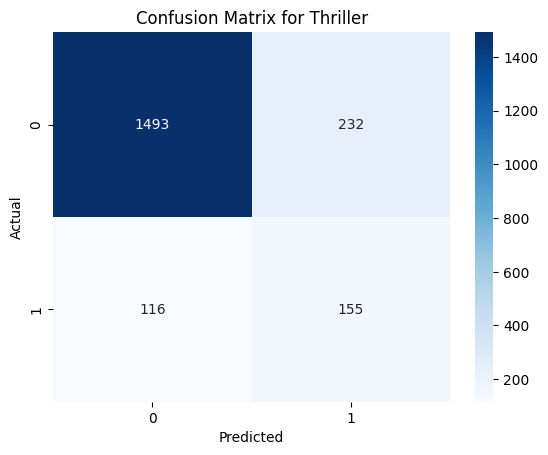

Genre: War


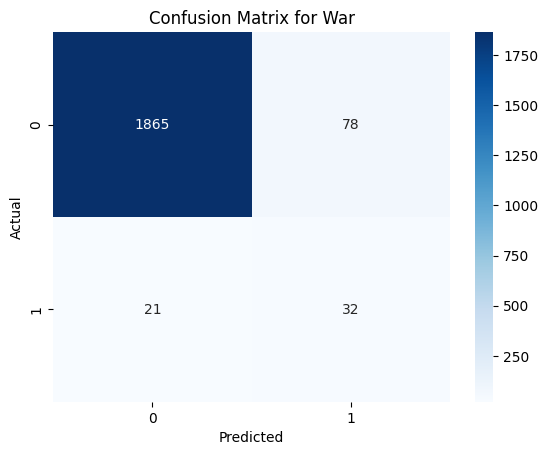

Genre: Western


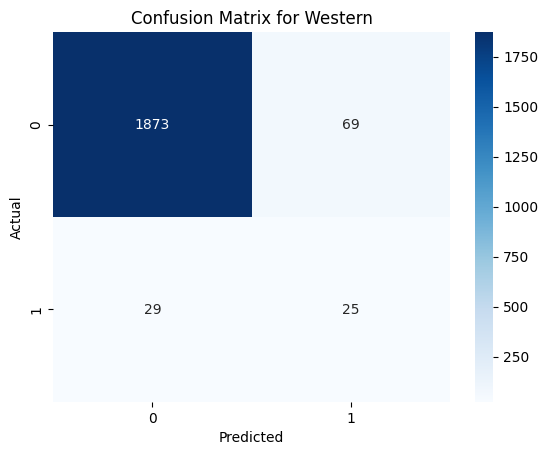

In [151]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

lstm_model.eval()

with torch.no_grad():
    preds = lstm_model(X_test)            # tensor
    preds = (preds >= 0.8).int()          # threshold
    preds = preds.cpu().numpy()           # → numpy
    y_true = y_test.cpu().numpy()          # → numpy

for genre in mlb.classes_:
    print("Genre:", genre)
    idx = list(mlb.classes_).index(genre)

    cm = confusion_matrix(y_true[:, idx],preds[:, idx])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {genre}")
    plt.show()


In [152]:
text = "A space adventure with war and heroic sacrifice"
doc = nlp(text)
tokens = [token.text.lower() for token in doc if token.pos_ not in {"SPACE","X","SYM"} and token.is_alpha]
seq = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
seq = seq[:MAX_LEN]

if len(seq) < MAX_LEN:
    seq = np.vstack([seq, np.zeros((MAX_LEN - len(seq), EMBED_DIM))])

x = torch.FloatTensor(seq).unsqueeze(0).to(device)
lstm_model.eval()
with torch.no_grad():
    logits = lstm_model(x)
    probs = torch.sigmoid(logits)

threshold = 0.8
pred = (probs >= threshold).int().cpu().numpy()[0]


predicted_genres = [mlb.classes_[i] for i, v in enumerate(pred) if v == 1]
print(predicted_genres)


['Action', 'Adventure', 'Animation', 'Fantasy', 'War']


In [156]:
thresholds = {
    "Comedy": 0.6,
    "Drama": 0.6,
    "Documentary": 0.75,
    "War": 0.9,
    "TV Movie": 0.5,
}

pred = probs[0]
genres = []

for i, genre in enumerate(mlb.classes_):
    th = thresholds.get(genre, 0.8)
    if pred[i] >= th:
        genres.append(genre)

print(genres)

['Action', 'Adventure', 'Animation', 'Fantasy']
